In [17]:
%matplotlib inline

import numpy as np
from collections import OrderedDict
import pandas as pd
from datetime import datetime, timedelta
from matplotlib.dates import date2num, num2date

import os
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MaxNLocator
from matplotlib.dates import MonthLocator
from matplotlib.dates import DayLocator
import matplotlib.patches as mpatches



In [18]:
def apply_plot_params(font_size=20, width_pt=1000, aspect_ratio=1, height_cm=None, width_cm=None):
    """
    aspect_ratio = height / (width * golden_mean)
    """
    import pylab
    import math

    if width_pt is not None and width_cm is None:
        inches_per_pt = 1.0 / 72.27  # Convert pt to inch
        golden_mean = (math.sqrt(5.0) - 1.0) / 2.0  # Aesthetic ratio
        fig_width = width_pt * inches_per_pt  # width in inches
        fig_height = fig_width * golden_mean  # height in inches
        fig_size = [fig_width, aspect_ratio * fig_height]
    else:
        inches_per_cm = 1.0 / 2.54
        width_cm = 16.0 if width_cm is None else width_cm
        height_cm = 23.0 if height_cm is None else height_cm
        fig_size = [width_cm * inches_per_cm, height_cm * inches_per_cm]

    params = {
        'axes.labelsize': font_size,
        'font.size': font_size,
        'legend.fontsize': font_size,
        'xtick.labelsize': font_size,
        'ytick.labelsize': font_size,
        'figure.figsize': fig_size,
        "axes.titlesize": font_size
    }

    pylab.rcParams.update(params)


In [85]:
# get data
#data_dir = "/home/san/CNRCWP/Calgary_flood/data_for_sasha_1_year_new"
#data_dir = "/Users/huziy/CNRCWP/Floods/data_for_sasha_1_year_new"
data_dir = "/Users/huziy/CNRCWP/Floods/Banff"

title = os.path.basename(data_dir)

# If using labels for the first version of the data
id_to_label = {
    "dryAB_4": "dry_AB",
    "satAB_4": "saturated_AB",
    'NA-Arman-0.11d-Jun14-SN_satABfrozBow-201306_4': "saturated_AB_frozen",
    'NA-Arman-0.11d-Jun14-SN-satABfrozsnowBow-201306_4': "saturated_AB_snow",
    'NA_Arman_0.11d_Jun14_noSN_State_201306_4': "????",
    'NA-Arman-0.11d-Jun14-SN-frozSoilSnowBowNoDrain-201306_4': "frozen_snow_nodrain",
    'NA-Arman-0.11d-Jun14-SN-frozSoilSnowBow-201306_4': "frozen_snow"
}

ordered_labels = ["Obs.", "Obs. clim.", "Control", 'NA_Arman_0.11d_Jun14_noSN_State_201306_4', "dryAB_4", "satAB_4",
                 "NA-Arman-0.11d-Jun14-SN-frozSoilSnowBow-201306_4",
                  'NA-Arman-0.11d-Jun14-SN_satABfrozBow-201306_4',
                  'NA-Arman-0.11d-Jun14-SN-frozSoilSnowBowNoDrain-201306_4',       ]

##################################################
derive_label_from_fname = True

read_std = True
if read_std:
    clim_std = pd.read_csv(os.path.join(data_dir, "std.txt"), skiprows=1, sep="\s+", 
                     names=["std"], 
                     header=None, index_col=0)


if derive_label_from_fname:
    id_to_label = {}
    ordered_labels = ["Obs.", "Obs. clim.",  
                       "dryABNoDrain", "satABNoDrain", 
                      "satABfrozBowNoDrain", "satABfrozSnowBowNoDrain"]

    ordered_labels = ordered_labels[:2] + [lbl + "_4" for lbl in ordered_labels[2:]]

data_yearly = None
skiprows = 2

dates = None
sel_cols = None


for f in os.listdir(data_dir):
    
    if not f.endswith(".txt"):
        continue
    
    label = f[:-4]
    try:
        if derive_label_from_fname:
            label = label.split("_")[-2]
    except Exception:
        continue
        
    
    sel_cols = list(range(5))  
        
    print(sel_cols)

    df = pd.read_csv(os.path.join(data_dir, f), skiprows=skiprows, sep="\s+", 
                     names=["{}_{}".format(label, col) for col in sel_cols], 
                     header=None, index_col=0)
    
    
    
    if data_yearly is None:
        data_yearly = df
    else:
        data_yearly = pd.concat([data_yearly, df], axis=1)
    
    print(label)
        
# delete unnecessary (since the same in all files)
for cname in data_yearly.columns[4:]:
    if "_" in cname:
        if int(cname.split("_")[-1]) in [1, 3]:
            del data_yearly[cname]

for cname in data_yearly.columns:
    if "_" in cname:
        if int(cname.split("_")[-1]) in [2, ]:
            del data_yearly[cname]


        
        
data_yearly.columns = [c.replace("simulation_1_year", "").replace("snow","Snow") for c in data_yearly.columns]

print(data_yearly.columns)



data_yearly.columns = [ "Obs." if c.endswith("1") else c for c in data_yearly.columns]
data_yearly.columns = [ "Obs. clim." if c.endswith("3") else c for c in data_yearly.columns]
# data_yearly.columns = [ "Control" if c.endswith("2") else c for c in data_yearly.columns]


print(data_yearly.head())

# Make observations to be the first columns
new_order = ["Obs.", "Obs. clim."] if title.lower().endswith("banff") else []
new_order += [c for c in ordered_labels[2:] if c not in new_order]
data_yearly = data_yearly[new_order]

print(new_order)
print(data_yearly.head())
print(ordered_labels)


if dates is None:
    d0 = datetime(2013, 1, 1)
    dates = [d0 + timedelta(days=nd-1) for nd in data_yearly.index]
    data_yearly["date"] = dates
    data_yearly.set_index("date", inplace=True)
    
    if read_std:
        clim_std["date"] = dates
        clim_std.set_index("date", inplace=True)

    
    
data_yearly = data_yearly[new_order]

print(new_order)

    
data_yearly.columns = [id_to_label.get(c, c) for c in data_yearly.columns]
data_yearly.columns = [c if not c.endswith("_4") else c[:-2] for c in data_yearly.columns]

# select only nodrain sims
data_yearly = data_yearly[list(data_yearly.columns[:2]) + [c for c in data_yearly.columns[2:] if "nodrain" in c.lower()]]


data_yearly.columns = [c.replace("NoDrain", "").replace("AB", "").replace("froz", "Frozen").replace("sat", "Sat").replace("dry", "Dry").replace("Bow", "") for c in data_yearly.columns]



data_yearly.head()

[0, 1, 2, 3, 4]
dryAB
[0, 1, 2, 3, 4]
dryABNoDrain
[0, 1, 2, 3, 4]
satAB
[0, 1, 2, 3, 4]
satABfrozBow
[0, 1, 2, 3, 4]
satABfrozBowNoDrain
[0, 1, 2, 3, 4]
satABfrozsnowBow
[0, 1, 2, 3, 4]
satABfrozsnowBowNoDrain
[0, 1, 2, 3, 4]
satABNoDrain
Index(['dryAB_1', 'dryAB_3', 'dryAB_4', 'dryABNoDrain_4', 'satAB_4',
       'satABfrozBow_4', 'satABfrozBowNoDrain_4', 'satABfrozSnowBow_4',
       'satABfrozSnowBowNoDrain_4', 'satABNoDrain_4'],
      dtype='object')
         Obs.  Obs. clim.   dryAB_4  dryABNoDrain_4   satAB_4  satABfrozBow_4  \
dryAB_0                                                                         
1        6.35         9.4  2.605731        2.605731  2.605731        2.605731   
2        5.92         9.5  1.832531        1.832531  1.832531        1.832531   
3        6.32         9.7  1.643931        1.643931  1.643931        1.643931   
4        6.55         9.7  1.432889        1.432889  1.432889        1.432889   
5        6.61         9.7  1.028352        1.028352  1.0

,Obs.,Obs. clim.,Dry,Sat,SatFrozen,SatFrozenSnow
date,,,,,,
2013-01-01,6.35,9.4,2.605731,2.605731,2.605731,2.605731
2013-01-02,5.92,9.5,1.832531,1.832531,1.832531,1.832531
2013-01-03,6.32,9.7,1.643931,1.643931,1.643931,1.643931
2013-01-04,6.55,9.7,1.432889,1.432889,1.432889,1.432889
2013-01-05,6.61,9.7,1.028352,1.028352,1.028352,1.028352


In [86]:
print(data_yearly.shape)
type(clim_std)
print(new_order)

(365, 6)
['Obs.', 'Obs. clim.', 'dryABNoDrain_4', 'satABNoDrain_4', 'satABfrozBowNoDrain_4', 'satABfrozSnowBowNoDrain_4']


In [87]:
from matplotlib.transforms import Bbox, TransformedBbox, \
     blended_transform_factory

from mpl_toolkits.axes_grid1.inset_locator import BboxPatch, BboxConnector,\
     BboxConnectorPatch
    


def connect_bbox(bbox1, bbox2,
                 loc1a, loc2a, loc1b, loc2b,
                 prop_lines, prop_patches=None):
    if prop_patches is None:
        prop_patches = prop_lines.copy()
        prop_patches["alpha"] = prop_patches.get("alpha", 1)*0.2

    c1 = BboxConnector(bbox1, bbox2, loc1=loc1a, loc2=loc2a, **prop_lines)
    c1.set_clip_on(False)
    c2 = BboxConnector(bbox1, bbox2, loc1=loc1b, loc2=loc2b, **prop_lines)
    c2.set_clip_on(False)

    bbox_patch1 = BboxPatch(bbox1, **prop_patches)
    bbox_patch2 = BboxPatch(bbox2, **prop_patches)

    p = BboxConnectorPatch(bbox1, bbox2,
                           #loc1a=3, loc2a=2, loc1b=4, loc2b=1,
                           loc1a=loc1a, loc2a=loc2a, loc1b=loc1b, loc2b=loc2b,
                           **prop_patches)
    p.set_clip_on(False)

    return c1, c2, bbox_patch1, bbox_patch2, p


def zoom_effect01(ax1, ax2, xmin, xmax, **kwargs):
    """
    ax1 : the main axes
    ax1 : the zoomed axes
    (xmin,xmax) : the limits of the colored area in both plot axes.

    connect ax1 & ax2. The x-range of (xmin, xmax) in both axes will
    be marked.  The keywords parameters will be used ti create
    patches.

    """

    trans1 = blended_transform_factory(ax1.transData, ax1.transAxes)
    trans2 = blended_transform_factory(ax2.transData, ax2.transAxes)

    bbox = Bbox.from_extents(xmin, 0, xmax, 1)

    mybbox1 = TransformedBbox(bbox, trans1)
    mybbox2 = TransformedBbox(bbox, trans2)

    prop_patches=kwargs.copy()
    prop_patches["ec"]="none"
    prop_patches["alpha"]=0.2

    c1, c2, bbox_patch1, bbox_patch2, p = \
        connect_bbox(mybbox1, mybbox2,
                     loc1a=3, loc2a=2, loc1b=4, loc2b=1,
                     prop_lines=kwargs, prop_patches=prop_patches)

    ax1.add_patch(bbox_patch1)
    ax2.add_patch(bbox_patch2)
    ax2.add_patch(c1)
    ax2.add_patch(c2)
    ax2.add_patch(p)

    return c1, c2, bbox_patch1, bbox_patch2, p


def zoom_effect02(ax1, ax2, **kwargs):
    """
    ax1 : the main axes
    ax1 : the zoomed axes

    Similar to zoom_effect01.  The xmin & xmax will be taken from the
    ax1.viewLim.
    """

    tt = ax1.transScale + (ax1.transLimits + ax2.transAxes)
    trans = blended_transform_factory(ax2.transData, tt)

    mybbox1 = ax1.bbox
    mybbox2 = TransformedBbox(ax1.viewLim, trans)

    prop_patches=kwargs.copy()
    prop_patches["ec"]="none"
    prop_patches["alpha"]=0.2

    c1, c2, bbox_patch1, bbox_patch2, p = \
        connect_bbox(mybbox1, mybbox2,
                     loc1a=3, loc2a=2, loc1b=4, loc2b=1,
                     prop_lines=kwargs, prop_patches=prop_patches)

    
    ax1.add_patch(bbox_patch1)
    ax2.add_patch(bbox_patch2)
    ax2.add_patch(c1)
    ax2.add_patch(c2)
    #ax2.add_patch(p)

    return c1, c2, bbox_patch1, bbox_patch2, p


In [90]:
# entry point

from matplotlib import colors
from matplotlib.colors import ListedColormap

def plot_dataframe(df, title):
    gs = GridSpec(2, 3, width_ratios=[1, 1, 1])
    apply_plot_params(width_cm=25, height_cm=30)
    fig = plt.figure()
    ax1 = fig.add_subplot(gs[0, 1])
    ax2 = plt.subplot(gs[1, :])
    # ax2.set_xlim(0, 1)
    # ax2.set_xlim(0, 5)

    ax1.set_title(title)
    
    print(df.columns)
    colors = ["r", "b", "g", "y", "m", "k", "c"][:6]
    cmap = ListedColormap(colors)
    
    
    styles = []
    for i, c in enumerate(colors):
        if i < 2:
            styles.append(c)
        else:
            styles.append(c + "--")
    

    
    if title.lower().endswith("banff"):
        # upper panel (zoom)
        df.plot(x=df.index, y=list(df.columns[:2]) + [c for c in df.columns[2:]], linewidth=3, ax=ax1, 
                legend=False, style=styles)
        
        # lower panel
        df.plot(x=df.index, y=[df.columns[i] for i in (0, 1)], linewidth=3, ax=ax2, 
                legend=False, grid=True, color=colors)

        ax1.fill_between(df.index, df["Obs. clim."], df["Obs. clim."] + 2 * clim_std["std"], facecolor="b", alpha=0.5, 
                         label="[Obs. clim., Obs. clim. + 2 * std]")
    
        p = mpatches.Rectangle((0, 0), 0, 0, color="b", alpha=0.5, label="[Obs. clim., Obs. clim. + $2 \sigma$]")
        ax1.add_patch(p)
        lg = ax1.legend(handles= ax1.lines + [p], bbox_to_anchor=(3.2, 1), loc="upper right", borderaxespad=0.)
        lg.draw_frame(False)
    else:
        df.plot(x=df.index, ax=ax2)
        ax2.set_visible(False)

        # upper panel (zoom)
        df.plot(x=df.index, y=[c for c in df.columns], linewidth=3, ax=ax1, 
                legend=False, style=styles[2:])

        
        lg = ax1.legend(handles= ax1.lines, bbox_to_anchor=(2.5, 1), loc="upper right", borderaxespad=0.)
        lg.draw_frame(False)

    
    # ax2.fill_between(df.index, df["Obs. clim."]  + clim_std["std"], df["Obs. clim."] + 2 * clim_std["std"], 
    #                 facecolor="b", alpha=0.8, label="[clim + std, clim + 2 * std]", zorder=6)
    
    # ax2.legend()

    zoom_start = datetime(2013, 6, 19)
    zoom_end = datetime(2013, 6, 26)

    ax1.set_xlim(zoom_start, zoom_end)
    print(ax2.get_xlim())
    print(ax1.get_xlim())

    zoom_effect02(ax1, ax2, linestyle="solid", color="0.2", linewidth=0.5)

    # format axes
    ax1.set_ylabel(ylabel=r"$\left[{\rm m^3/s} \right]$")
    ax1.set_xlabel("")
    ax1.yaxis.set_major_locator(MaxNLocator(nbins=6))
    ax1.xaxis.set_major_formatter(FuncFormatter(lambda d, pos: num2date(d).strftime("%d")))
    ax1.xaxis.set_minor_formatter(FuncFormatter(lambda d, pos: num2date(d).strftime("")))
    ax1.xaxis.set_minor_locator(DayLocator())
    ax1.xaxis.set_major_locator(DayLocator(interval=2))
    # ax1.xaxis.set_ticks([datetime(2013, 6, 19), datetime(2013, 6, 21), datetime(2013, 6, 23), datetime(2013, 6, 25)])
    # ax1.grid(False)

    ax2.set_ylabel(ylabel=r"$\left[{\rm m^3/s} \right]$")
    ax2.set_xlabel("")
    ax2.xaxis.set_minor_formatter(FuncFormatter(lambda d, pos: num2date(d).strftime("%b")[0]))
    ax2.xaxis.set_major_formatter(FuncFormatter(lambda d, pos: ""))
    ax2.xaxis.set_major_locator(MonthLocator(bymonthday=1))
    ax2.xaxis.set_minor_locator(MonthLocator(bymonthday=15))
    ax2.yaxis.set_major_locator(MaxNLocator(nbins=6))
    # ax2.grid(True)
    


    #gs.tight_layout(fig)

    fig.savefig("hydrographs_NoDrain_Banff.png", bbox_inches="tight")


Index(['Obs.', 'Obs. clim.', 'Dry', 'Sat', 'SatFrozen', 'SatFrozenSnow'], dtype='object')
(15706.0, 16070.0)
(15875.0, 15882.0)


/Users/huziy/virtualenvs/py3.4-default/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


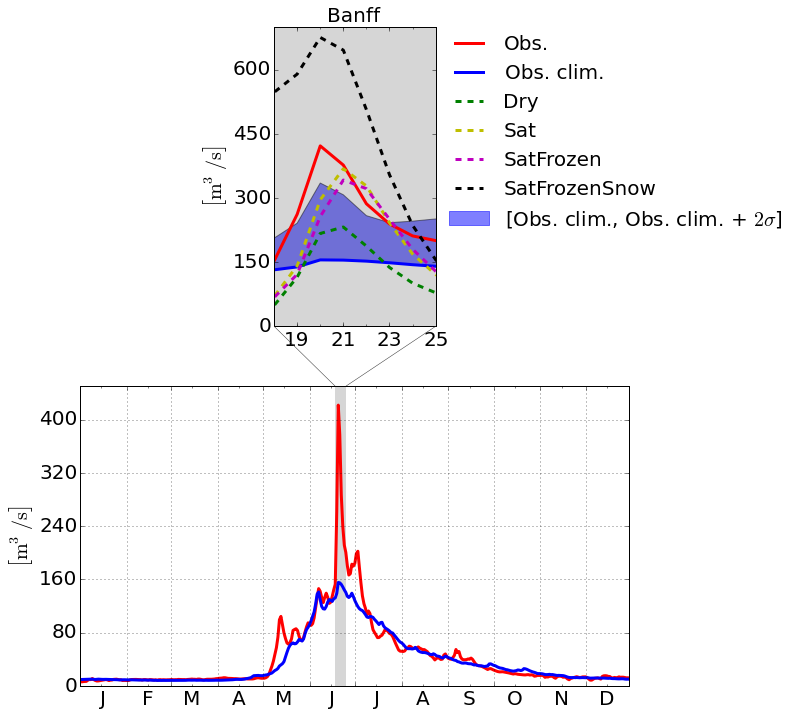

In [91]:

plot_dataframe(data_yearly, title)